# 1. Necessary imports and display settings

In [135]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Common libraries
import numpy as np
import pandas as pd
display_settings = {
    'max_rows': 7,
    'max_columns': 7,
    'precision': 2
}
for op, value in display_settings.items():
    pd.set_option("display.{}".format(op), value)

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 4})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Estimators
from sklearn.cluster import KMeans
from sklearn.svm import SVC

# Preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from collections import Counter
from imblearn.under_sampling import *
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Metrics
from sklearn import metrics

# 2. Preprocessing

## 2.1 Loading the data

In [136]:
df = pd.read_csv("../dataset/creditcard.csv")
df.head(5)

,Time,V1,V2,...,V28,Amount,Class
0,0.0,-1.36,-0.07,...,-0.02,149.62,0
1,0.0,1.19,0.27,...,0.01,2.69,0
2,1.0,-1.36,-1.34,...,-0.06,378.66,0
3,1.0,-0.97,-0.19,...,0.06,123.50,0
4,2.0,-1.16,0.88,...,0.22,69.99,0


Creating 80/20 split of dataset and also scaling the features.

In [137]:
samples_untouched = df.drop(columns='Class')
labels_untouched = df['Class'].ravel()

In [138]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_train, X_test, y_train, y_test = train_test_split(samples_untouched, labels_untouched, test_size=0.2, random_state=8)
features = X_train.columns
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=features)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=features)

# Used in case of outlier removal
train_df = pd.concat([X_train, pd.DataFrame(y_train, columns=['Class'])], axis=1)
neg_samples = train_df.loc[train_df['Class'] == 0]
pos_samples = train_df.loc[train_df['Class'] == 1]

## 2.2 Exploring the dataset

**Finding 1**: There are no missing values in the dataset.

In [6]:
samples_untouched.isnull().sum()

Time      0
V1        0
V2        0
         ..
V27       0
V28       0
Amount    0
Length: 30, dtype: int64

**Finding 2**: There are significantly more negative samples than positive samples.

In [129]:
print(f'Number of negative samples: {Counter(labels_untouched)[0]}\nNumber of positive samples: {Counter(labels_untouched)[1]}')

Number of negative samples: 284315
Number of positive samples: 492


## 2.3 Oversampling via SMOTE (unused)

In [78]:
sm = SMOTE(random_state=42, n_jobs=-1, sampling_strategy=0.3)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(f'Number of negative samples: {Counter(y_train)[0]}\nNumber of positive samples: {Counter(y_train)[1]}')

Number of negative samples: 284315
Number of positive samples: 85294


## 2.4 Undersampling (unused)

In [68]:
us = NearMiss()
X_train, y_train = us.fit_resample(X_train, y_train)
print(f'Number of negative samples: {Counter(y_train)[0]}\nNumber of positive samples: {Counter(y_train)[1]}')

Number of negative samples: 14215
Number of positive samples: 14215


## 2.5 Outlier removal (unused)

In [119]:
isof = IsolationForest(contamination=0.04, n_jobs=-1, random_state=42)
y_pred = isof.fit_predict(neg_samples)
non_outlier_mask = y_pred != -1

In [120]:
neg_samples = neg_samples[non_outlier_mask]
print(neg_samples.shape[0])

218355


In [121]:
X_train = pd.concat([neg_samples, pos_samples])
X_train.reset_index(drop=True, inplace=True)
y_train = X_train['Class'].ravel()
X_train.drop(columns=['Class'], inplace=True)

# 3. Clustering

## K-Means clustering

**Note:** The given dataset is already classified, hence we could simply skip this step and instead use the domain size of the labels as the number of clusters; However, a heuristic (in this case the Elbow method) was used to find the optimal number of clusters for demonstration's sake.

### Part 1) Finding the optimal number of clusters for K-Means clustering via the Elbow method

In [18]:
inertia_values = [] 
for i in range(1, 5): 
    kmeans_clusterer = KMeans(n_clusters = i, init = 'k-means++', random_state = 1)
    kmeans_clusterer.fit(samples) 
    inertia_values.append(kmeans_clusterer.inertia_)

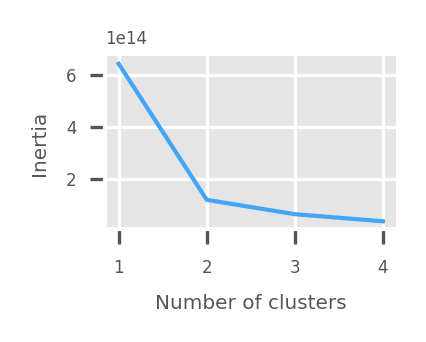

In [19]:
plt.figure(figsize=(1.25,0.75))
plt.plot(
    range(1, 5), inertia_values,
    color = "#42A5F5",
    linewidth = '1'
    )
plt.xticks(range(1,5))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia') 
plt.show()

The elbow occured at $k = 2$, hence 2 is the optimal number of clusters (which is in agreement with number of classes).

### Part 2) Designating clusters

In [139]:
kmeans_clusterer = KMeans(n_clusters = 2, init = 'k-means++', n_init='auto', random_state = 1)
kmeans_clusterer.fit(samples_untouched)

KMeans(n_clusters=2, n_init='auto', random_state=1)

In [140]:
sample_cluster_mask = kmeans_clusterer.labels_

### Part 3) Measuring cluster purity

#### Overview

In order to measure clustering quality, we can use a metric known as "Cluster Purity".

In order to calculate cluster purity, we can first compute a confusion matrix to get the distribution of each class within each cluster, and then use a secondary function to calculate purity via the confusion matrix.

Since the cluster size and class domain size were both equal and a one-to-one correspondence is possible between clusters and classes, it is also helpful to visualize the confusion matrix (this would have been less helpful, for example, had we had 3 clusters but only 2 classes).

Sources for snippets of code used:
1. [Confusion matrix visualization](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)
2. [Calculation of purity from confusion matrix](https://stackoverflow.com/a/51672699)
    - [Information needed to correct above snippet](https://stats.stackexchange.com/questions/95731/how-to-calculate-purity)

#### Confusion matrix calculation and heatmap

<Axes: >

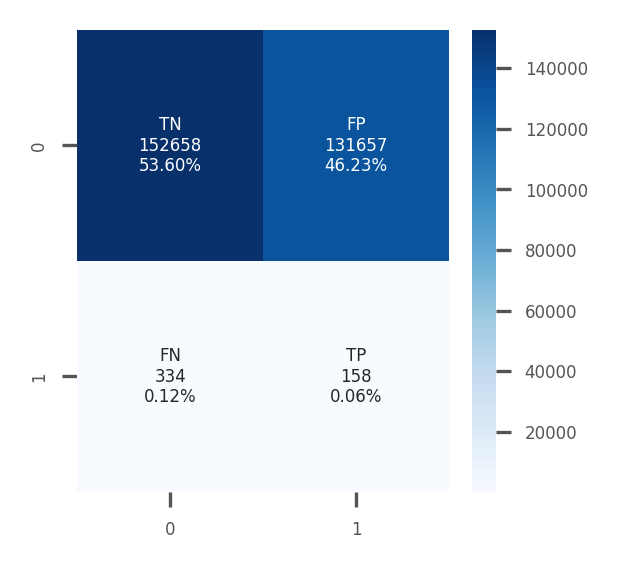

In [141]:
cf_matrix = metrics.cluster.contingency_matrix(labels_true=labels_untouched, labels_pred=sample_cluster_mask)
plt.figure(figsize=(2,2))
group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels_cf = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels_cf = np.asarray(labels_cf).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels_cf, fmt='', cmap='Blues')

#### Cluster purity computation

In [142]:
def purity_score(cf_matrix):
    return np.sum(max(np.max(cf_matrix, axis=0))) / np.sum(cf_matrix) 

In [143]:
print(f'Clustering purity: {purity_score(cf_matrix)}')

Clustering purity: 0.5360050841447015


#### Conclusion

As evident by both the results of the confusion matrix and the purity score, the clustering performance was very poor and barely better than randomized
clustering.

This can be attributed to two possible causes:
1. K-means performs worse when dealing with high dimensional data. This is due to the fact that the most typical implementation uses the Euclidean distance metric, which is not very well suited when comparing samples with a large number of features.
2. K-means clustering struggles to make meaningful clusters when the density of the "real" clusters is highly variable.

# 4. Classification

#### Overview

The estimator used for the classifications was an SVM classifier, whose hyperparameters were optimized using a parameter grid search. 

Since SVM classifiers are sensitive to the magnitude of the data, the features were first scaled to $(-1,1)$.

## 4.1 Preprocessing

## 4.2 Training the classifier

In [7]:
param_combinations = {'kernel':['sigmoid','rbf'],'C':[0.1, 1.0, 10], 'gamma':[0.01, 0.1, 1.0, 10.0]}
svm_classifier = SVC()

clf = GridSearchCV(estimator=svm_classifier, param_grid=param_combinations, cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.best_score_)
print(clf.best_params_)

poly_param_combinations = {'kernel':['poly'], 'C':[0.1, 1.0, 10], 'gamma':[0.01, 0.1, 1.0, 10.0], 'degree':[3, 4, 5]}
poly_svm_classifier = SVC()

clf_poly = GridSearchCV(estimator=poly_svm_classifier, param_grid=poly_param_combinations, cv=5, scoring='accuracy', n_jobs=-1)
clf_poly.fit(X_train, y_train)
print(clf_poly.best_score_)
print(clf_poly.best_params_)

0.9481301149901586
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.9511758002693462
{'C': 10, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}


Based on the results above, an SVM classifier with a polynomial kernel of degree seems to perform the best.

## 4.3 Performance evaluation

Building estimator with optimal params:

In [130]:
opt_clf = SVC(kernel='poly', degree=4)
opt_clf.fit(X_train, y_train)

SVC(degree=4, kernel='poly')

In [131]:
y_pred = opt_clf.predict(X_test)

In [132]:
print(f'Number of negative samples: {Counter(y_pred)[0]}\nNumber of positive samples: {Counter(y_pred)[1]}')

Number of negative samples: 56871
Number of positive samples: 91


### Confusion Matrix

<Axes: >

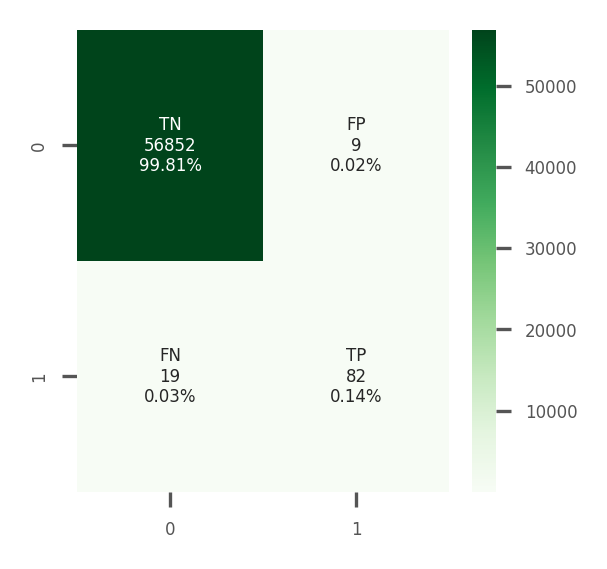

In [133]:
cf_matrix = metrics.cluster.contingency_matrix(labels_true=y_test, labels_pred=y_pred)
plt.figure(figsize=(2,2))
group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels_cf = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels_cf = np.asarray(labels_cf).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels_cf, fmt='', cmap='Greens')

### Recall/Precision Score

In [134]:
tp = cf_matrix[1][1]
tn = cf_matrix[0][0]
fp = cf_matrix[0][1]
fn = cf_matrix[1][0]

recall_score = tp/(tp+fn)
precision_score = tp/(tp+fp)
accuracy = (tp+tn)/(tp+tn+fn+fp)

print(f'Accuracy: {(accuracy)}\nRecall score: {recall_score}\nPrecision score: {precision_score}')

Accuracy: 0.9995084442259752
Recall score: 0.8118811881188119
Precision score: 0.9010989010989011


### Interpretation of the metrics

Overall, the SVM model performs relatively well, with decently high recall score and high precision score. The accuracy, albeit measured, is not a useful metric in this case because of the imbalance in the number of negative and positive samples. The model has a slightly low sensitivity reflected in its lower recall score; However, the model makes up for it with higher precision.

# 5. Conclusion

Since our dataset had already been labeled, using supervised learning methods gives better results.

For the purpose of detecting credit fraud, aside from a model that is sensitive enough, we require an estimator that has a substantially high precision score as to not flag innocent customers as frauds. The SVM classifier trained flags approximately 4 out of every 5 fradulent records and boasts a reliably high precision score of 90%, allowing the user to make more confident decisions about whether a customer has committed fraud or not.